In [1]:
import numpy as np
import segyio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
from scipy import signal

In [2]:
from ukpgks import segy
from ukpgks import plots
from ukpgks import rss
from ukpgks import signal

In [3]:
# read real data
decon_data,_ = segy.read_segy('data_decon.sgy')
# read models
model_wd,_ = segy.read_segy('Pmods_w_d.sgy')
model_wg,_ = segy.read_segy('Pmods_w_g.sgy')
model_wd6,_=  segy.read_segy('Pmods_wd_6.sgy')
model_wd3,_=  segy.read_segy('Pmods_wd_3.sgy')

In [4]:
# read zero phase wavelter used to model data
wd = rss.read_rssdata('06_wav_d.rss')
wd6 = rss.read_rssdata('wd_6.rss')
wd3 = rss.read_rssdata('wd_3.rss')

In [5]:
# read weights
weights = rss.read_rssdata('weight_2.rss')

In [6]:
print (decon_data.shape,model_wd.shape,wd.shape,weights.shape)

(3800, 1001) (3800, 1001) (10001,) (1001, 3800)


In [7]:
# resample datasets
data  = signal.resample(decon_data.T,0.01,0.001)
model = signal.resample(model_wd.T,0.01,0.001)
weight = signal.resample(weights,0.01,0.001)
print (data.shape,model.shape,wd.shape,weight.shape)

(10001, 3800) (10001, 3800) (10001,) (10001, 3800)


In [8]:
# mute data 
data_m  = data  * weight
model_m = model * weight

In [25]:
# plots.plot2D_shot(model_wd[:60,:])
# plt.plot(wd[:4000])
# plots.plot2D_shot(data[:,:90].T,size=(14,8))
# plots.plot2D_shot(data_m[:,:90].T,size=(14,8))

In [44]:
# scale datasets 
sc1_data  = standart_scale(data_m)
sc1_model= standart_scale(model_m)

sc2_data  = normalize(data_m,between=(0,1))
sc2_model= normalize(model_m,between=(0,1))

wd1 = normalize(wd)
wd2 = normalize(wd)


30194.897210456482 3480537.2925074263 25160.15234375


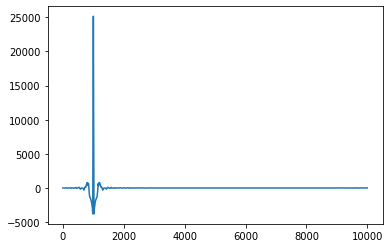

In [13]:
# plt.plot(wdscaled,'-')
plt.plot(wd,'-')
print (data_m.max(),model_m.max()*0.01,wd.max())

In [14]:
def source_estimation(data,model,model_wavelet,eps=None):
    ntrace,nt = data.shape[1],data.shape[0]
    transfer_cmp = np.zeros((nt,ntrace),dtype=np.complex)
    
    # print (transfer_cmp.shape)
    for j in range(ntrace):
        df = np.fft.fft(data[:,j])
        mf = np.fft.fft(model[:,j])
        # Computing transfer function
        amp = np.real(mf * np.conj(mf))
        transfer_cmp[:,j] = ((df) * np.conj(mf))  / (amp + eps**2)
    # Scaling result with number of traces
    scale = 2.0 / ntrace
    transfer_cmp *=scale
    transfer_cmp = np.sum(transfer_cmp,axis=1)
    
    wf = np.fft.fft(model_wavelet)
    wavelet_cmp = transfer_cmp * wf
    
    # Inverse Fourier to obtain wavelet
    wavelet = np.fft.ifft(wavelet_cmp)
    # wavelet = np.fft.ifftshift(wavelet) 
    
    return wavelet        

In [15]:
w = source_estimation(data_m,model_m,wd,eps=model_m.max()*0.05)

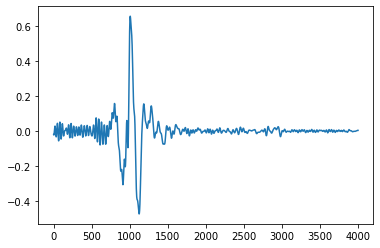

In [21]:
plt.plot(np.real(w[:4000]))

In [20]:
w1 = source_estimation(sc1_data,sc1_model,wd1,eps=30)

1.0


30.350204250225104


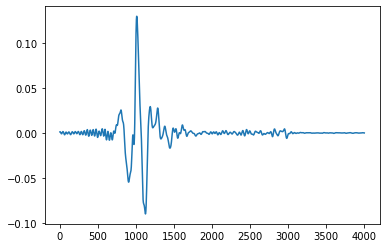

In [24]:
plt.plot(np.real(w1[:4000]))
print (sc1_data.max())

In [50]:
w2 = source_estimation(sc2_data,sc2_model,wd2,eps=0.3)

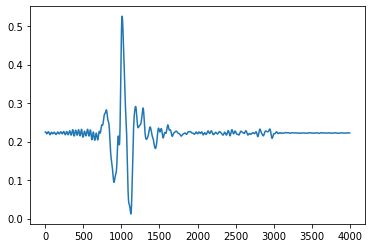

In [51]:
# plt.plot((wd33[:4000]),'r.',markersize=1)
rms = np.sqrt(np.mean(wd)**2)
plt.plot(np.real(w2[:4000]))

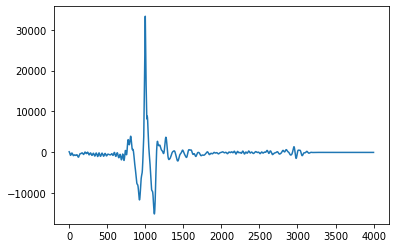

In [49]:
plt.plot((wd3[:4000]))
# plt.plot((wd6[:4000]))

In [10]:
def standart_scale(data):
    """
    Standardize features by removing the mean and scaling to unit variance
    The standard score of a sample x is calculated as:
    z = (x - u) / s
    
    input  - numpy array 
    output - scaled numpy array
    """
    scaled = (data - np.mean(data)) / np.std(data)
    return scaled

def normalize(data,between=(0,1)):
    """
    normalization 
    default min-max 
    or      [a,b]
    
    input  - numpy array 
    output - scaled numpy array
    """
    a,b = between[0],between[1]
    scaled = (b-a) * ( (data-np.min(data)) / (np.max(data) - np.min(data)) ) + a
    return scaled